## 1. LangGraph Example
### 1.1 Define the Graph State

In [22]:
from typing import Dict, TypedDict, Optional
class GraphState(TypedDict):
    question: Optional[str] = None
    classification: Optional[str] = None
    response: Optional[str] = None

### 1.2. Create the Graph

In [23]:
from langgraph.graph import StateGraph
workflow = StateGraph(GraphState)

### 1.3. Define Nodes & Add Nodes to the Graph

In [24]:
def classify(text: str) -> str:
    if "hello" in text.lower():
        return "greeting"
    return "search"

def classify_input_node(state):
    question = state.get('question', '').strip()
    classification = classify(question)  # Assume a function that classifies the input
    return {"classification": classification}

def handle_greeting_node(state):
    return {"response": "Hello! How can I help you today?"}

def handle_search_node(state):
    question = state.get('question', '').strip()
    search_result = f"Search result for '{question}'"
    return {"response": search_result}

workflow.add_node("classify_input", classify_input_node)
workflow.add_node("handle_greeting", handle_greeting_node)
workflow.add_node("handle_search", handle_search_node)

### 1.4. Define Edges & Add Edges to the Graph

In [25]:

def decide_next_node(state):
    return "handle_greeting" if state.get('classification') == "greeting" else "handle_search"

workflow.add_conditional_edges(
    "classify_input",
    decide_next_node,
    {
        "handle_greeting": "handle_greeting",
        "handle_search": "handle_search"
    }
)

from langgraph.graph import END, StateGraph, START

workflow.add_edge(START, 'classify_input')
workflow.add_edge('handle_greeting', END)
workflow.add_edge('handle_search', END)

### 1.5. Compile and Run the Graph

In [ ]:
graph = workflow.compile()
inputs = {"question": "Hello, how are you?"}
result = graph.invoke(inputs)

print(result)

{'question': 'Hello, how are you?', 'classification': 'greeting', 'response': 'Hello! How can I help you today?'}


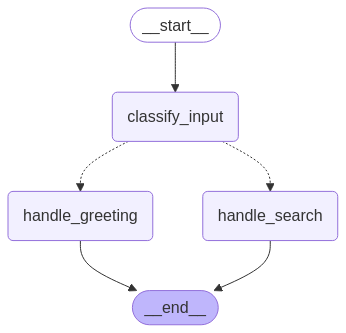

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 2. Simple RAG Example -- LangGraph Version


From **Step 1 to Step 9**, all components in our pipeline—such as loading the model, preparing the embeddings, storing vectors, and setting up the retriever—**remain exactly the same**. 

These steps are reusable across both the standard LangChain pipeline and the LangGraph implementation.

In [ ]:
# === Step 0: Import Dependencies ===
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnableLambda

# === Step 1: Configure LangSmith ===
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING", "false")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")


# === Step 2: Load Chat Model ===
llm = ChatOllama(
    model="qwen2.5:3b",                     # Use the Qwen 2.5 3B model
    base_url="http://34.142.153.30:11434",  # Replace with your Ollama server URL
    api_key="ollama"                        # Arbitrary string, not checked by Ollama
)


# === Step 3: Load Embedding Model ===
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")


# === Step 4: Load Vector Store ===
vectorstore = Chroma(
    embedding_function=embeddings,
    persist_directory="./chroma_db",        # Save vector data locally
    collection_name="my_docs"
)


# === Step 5: Load and Split Web Document ===
loader = WebBaseLoader(
    web_paths=["https://lilianweng.github.io/posts/2023-06-23-agent/"]
)
docs = loader.load()


# === Step 6: Split documents ===
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = splitter.split_documents(docs)


# === Step 7 Embedding and Storing Document Chunks ===
vectorstore.add_documents(splits)


# === Step 8: Define the Prompt Template ===
prompt = ChatPromptTemplate.from_template(
"""
Answer the question based on the following context:
--------------------
{context}
--------------------
Question: {question}
"""
)


# === Step 9: Build a Retriever from the Vector Store ===
retriever = vectorstore.as_retriever()

def combine_question_and_context(question):
    context = retriever.invoke(question)
    return {"question": question, "context": context}

USER_AGENT environment variable not set, consider setting it to identify your requests.
/opt/miniconda3/envs/GeneTest/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/GeneTest/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/miniconda3/envs/GeneTest/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/miniconda3/envs/GeneTest/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/GeneTest/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/GeneTest/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/GeneTest/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can 

Now, following the introduction from **1.3 Five Steps to Build a LangGraph Workflow**, 

let's rewrite **Step 10** of our RAG example in **Teaching Session #3**, 

focusing on how we define the retrieval logic using LangGraph.

In [37]:
# === Step 10: Build the Workflow by using LangGraph ===
from typing import Literal
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph
from langgraph.graph import END, StateGraph, START


# LangGraph-Step 1: Define the Graph State
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# LangGraph-Step 2: Create the Graph
workflow = StateGraph(State)

# LangGraph-Step 3: Define Nodes & Add Nodes to the Graph
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

workflow.add_sequence([retrieve, generate])

# LangGraph-Step 4: Define Edges & Add Edges to the Graph
workflow.add_edge(START, "retrieve")

# LangGraph-Step 5: Compile and Run the Graph
graph = workflow.compile()

Let’s draw a mermaid diagram to illustrate the flow of our RAG pipeline.


In [50]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

ValueError: Failed to render the graph using the Mermaid.INK API. Status code: 521.

In [34]:
def rag_answer(question: str) -> str:
    result = graph.invoke({"question": question})
    return result["answer"]

question = "What is Task Decomposition?"
answer = rag_answer(question)

print("🔎 Question:", question)
print("🧠 Answer:", answer)


🔎 Question: What is Task Decomposition?
🧠 Answer: Task decomposition involves breaking down a complex problem or task into smaller, more manageable subtasks or steps. This approach helps in understanding and solving problems by addressing them piece-by-piece.

In the context of Tree of Thoughts (Yao et al., 2023), task decomposition is done in one of three ways:
1. By using an LLM (Large Language Model) with simple prompting, like "Steps for XYZ.\n1.", or "What are the subgoals for achieving XYZ?"
2. Using task-specific instructions; e.g., writing a story outline for those who need to write a novel.
3. With human inputs.

By decomposing tasks into smaller steps, it becomes easier to reason about and solve problems more effectively.


## 3. Agentic RAG Example in LangGraph Version
### 3.1 LangSmith

In [80]:
# === Step 1: Configure LangSmith ===
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING", "false")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")

### 3.2 Retriever

In [81]:
# === Step 2: Load Embedding Model ===
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")


# === Step 3: Load Vector Store ===
vectorstore = Chroma(
    embedding_function=embeddings,
    persist_directory="./agentic_rag_db",
    collection_name="my_docs"
)


# === Step 4: Load and Split Web Document ===
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]


# === Step 5: Split documents ===
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)


# === Step 7 Embedding and Storing Document Chunks ===
vectorstore.add_documents(doc_splits)


# === Step 8: Build a Retriever from the Vector Store ===
retriever = vectorstore.as_retriever()

/var/folders/8n/w41cv82906x0yvx_g85scy680000gn/T/ipykernel_90525/2476117886.py:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [82]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

### 3.3 LangGraph
#### Define Agent State

In [83]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

#### Define Node and Edges
##### Edges

In [84]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_ollama import ChatOllama

from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition

### Edges
"""
  Determines whether the retrieved documents are relevant to the question.
  Args:
      state (messages): The current state
  Returns:
      str: A decision for whether the documents are relevant or not,return 'generate' or 'rewrite'
"""
def evaluate_documents(state) -> Literal["generate", "rewrite"]:
    print("---------CHECK RELEVANCE---------")
    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOllama(
        model="qwen2.5:3b",
        base_url='http://34.142.153.30:11434',
        api_key='ollama',
        temperature=0
    )

    # LLM with tool and validation
    # When you call it, please output the JSON format structure according to the definition of the grade class
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"] # take the message out from the AgentState
    last_message = messages[-1]

    question = messages[0].content # take the question out
    docs = last_message.content # take the docs out

    scored_result = chain.invoke({"question": question, "context": docs}) # use our evaluate chain to judge a score
    score = scored_result.binary_score

    if score == "yes":
        print("---------DECISION: DOCS IS RELEVANT---------")
        return "generate"

    else:
        print("---------DECISION: DOCS IS NOT RELEVANT---------")
        return "rewrite"


##### Agent Node

In [86]:

### Nodes
"""
  Invokes the agent model to generate a response based on the current state. Given
  the question, it will decide to retrieve using the retriever tool, or simply end.
  Args:
      state (messages): The current state
  Returns:
      dict: The updated state with the agent response appended to messages
"""
def agent(state):
    print("---------CALL AGENT---------")
    messages = state["messages"]
    model = ChatOllama(
        model="qwen2.5:3b",
        base_url='http://34.142.153.30:11434',
        api_key='ollama',
        temperature=0
    )
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

##### Rewrite Node

In [87]:
"""
  Transform the query to produce a better question.
  Args:
      state (messages): The current state
  Returns:
      dict: The updated state with re-phrased question
"""
def rewrite(state):
    print("---------TRANSFORM QUERY---------")
    messages = state["messages"]
    question = messages[0].content
    
    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOllama(
        model="qwen2.5:3b",
        base_url='http://34.142.153.30:11434',
        api_key='ollama',
        temperature=0.5
    )
    response = model.invoke(msg)
    return {"messages": [response]}

##### Generate Node

In [89]:
"""
  Generate answer
  Args:
      state (messages): The current state
  Returns:
       dict: The updated state with re-phrased question
"""
def generate(state):
    print("---------GENERATE---------")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOllama(
        model="qwen2.5:3b",
        base_url='http://34.142.153.30:11434',
        api_key='ollama',
        temperature=0.3
    )

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


#### Compile and Run the Graph

In [90]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode


# Define a new graph
workflow = StateGraph(AgentState)

# Add the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node("generate", generate)  # Generating a response after we know the documents are relevant

# Add edges
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision (Official provided judge)
    tools_condition,
    {
        "tools": "retrieve", # If the agent calls the tool → jump to the retrieve node
        END: END, # Else, the agent replies directly → jump to the END node
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision (Logic DIY by ourselves before)
    evaluate_documents, # Decide whether to jump generate or rewrite
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

#### visualize the compiled graph

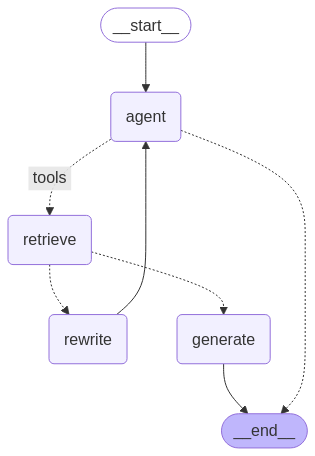

In [91]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# If cannot display the image, use the following code to display the graph in markdown format, 
# and then copy the mermaid code to a mermaid live editor to visualize it.
# https://mermaid.live/

# from IPython.display import Markdown

# mermaid_src = graph.get_graph().draw_mermaid()
# display(Markdown(f"```mermaid\n{mermaid_src}\n```"))


Finally, let's call the `graph.steam()` method to execute the graph and see the results.

In [96]:
import pprint
from langchain_core.messages import HumanMessage

inputs = {
    "messages": [
        HumanMessage(content="What does the blog say about the agent System Overview?")
    ]
}

for output in graph.stream(inputs): # actually run the graph we use .stream instead of .invoke
    for key, value in output.items():
        print(f"Output from node {key}:")
        pprint.pprint(value, indent=2, width=80, depth=None)
    print("\n")

---------CALL AGENT---------
Output from node agent:
{ 'messages': [ AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:3b', 'created_at': '2025-04-21T11:53:44.378402316Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1344579228, 'load_duration': 22419886, 'prompt_eval_count': 193, 'prompt_eval_duration': 287396092, 'eval_count': 23, 'eval_duration': 1027466822, 'message': Message(role='assistant', content='', images=None, tool_calls=None), 'model_name': 'qwen2.5:3b'}, id='run-42da2506-61c5-4c40-9dc9-739b12444bc1-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'agent System Overview'}, 'id': '78f99ef1-a266-4d2a-82d6-3a2597943675', 'type': 'tool_call'}], usage_metadata={'input_tokens': 193, 'output_tokens': 23, 'total_tokens': 216})]}


---------CHECK RELEVANCE---------
---------DECISION: DOCS IS NOT RELEVANT---------
Output from node retrieve:
{ 'messages': [ ToolMessage(content='Table of Contents\n\n\n\nAgent System Overview\n\

Try to run a bad query to see how the agent handles it.

In [93]:
import pprint
from langchain_core.messages import HumanMessage

inputs = {
    "messages": [
        HumanMessage(content="type?")
    ]
}

for output in graph.stream(inputs): # actually run the graph we use .stream instead of .invoke
    for key, value in output.items():
        print(f"Output from node {key}:")
        pprint.pprint(value, indent=2, width=80, depth=None)
    print("\n")

---------CALL AGENT---------
Output from node agent:
{ 'messages': [ AIMessage(content="Could you please provide more context or a specific question? I'm ready to help with information about Lilian Weng's blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs. What exactly would you like to know?", additional_kwargs={}, response_metadata={'model': 'qwen2.5:3b', 'created_at': '2025-04-21T11:49:53.90666668Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3375753975, 'load_duration': 23171838, 'prompt_eval_count': 184, 'prompt_eval_duration': 172044193, 'eval_count': 52, 'eval_duration': 3173144160, 'message': Message(role='assistant', content="Could you please provide more context or a specific question? I'm ready to help with information about Lilian Weng's blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs. What exactly would you like to know?", images=None, tool_calls=None), 'model_name': 'qwen2.5:3b'}, id='run-fc02679e-0668-4

In [94]:
import pprint
from langchain_core.messages import HumanMessage

inputs = {
    "messages": [
        HumanMessage(content="What does the blog say about LoRA vs PEFT?")
    ]
}

for output in graph.stream(inputs): # actually run the graph we use .stream instead of .invoke
    for key, value in output.items():
        print(f"Output from node {key}:")
        pprint.pprint(value, indent=2, width=80, depth=None)
    print("\n")

---------CALL AGENT---------
Output from node agent:
{ 'messages': [ AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:3b', 'created_at': '2025-04-21T11:50:08.01418519Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1879387139, 'load_duration': 22102297, 'prompt_eval_count': 194, 'prompt_eval_duration': 306765938, 'eval_count': 25, 'eval_duration': 1543245782, 'message': Message(role='assistant', content='', images=None, tool_calls=None), 'model_name': 'qwen2.5:3b'}, id='run-81da2bcb-035a-4eaf-aabf-4991cc568365-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'LoRA vs PEFT'}, 'id': '52ded606-a1d4-4a9f-9fcc-14b4a3e993d2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 194, 'output_tokens': 25, 'total_tokens': 219})]}


---------CHECK RELEVANCE---------
---------DECISION: DOCS IS NOT RELEVANT---------
Output from node retrieve:
{ 'messages': [ ToolMessage(content='FIFO: Can replace the seed hand-curated examples, and thus 